# Reddit & Emojis
## An analysis and visualization of Reddit sentiments

### Introduction and Background
***
![Reddit Logo](https://upload.wikimedia.org/wikipedia/en/thumb/8/82/Reddit_logo_and_wordmark.svg/320px-Reddit_logo_and_wordmark.svg.png)

#### What is Reddit?
Reddit is a social news aggregation site and discussion board that houses many interactive communities. These communities, termed "subreddits", each have a particular thematic focus that collectively spans many aspects of pop culture. We will study the nature of the discourses held within these many, perhaps culturally idiosyncratic, communities and attempt to visualize the diverse array of underlying sentiments that pervade the intra-communal interactions amongst their members.

#### Overview
In our endeavor to map the emotional contents of various subreddit communities, we will have to choose some form of sentiment analysis to conduct on each comment observation from our dataset. Sentiment analysis refers to the process of computationally extracting and quantifying the emotions, attitudes, and opinions expressed through textual data and is a specific subfield of the much broader discipline of natural language processing (NLP). Recent studies within this field into social media sentiments have successfully utilized a variety of noisy labels ranging from a handful of emoticons to assortments of hashtags as a form of distant supervision. Following this paradigmn, we will be incorporating a Deep Neural Network for sentiment classification that is detailed in a relatively recent paper published by Felbo et. al [1]. This work introduces an interesting approach to classifying textual data into sentimental categories of (64) relevant emojis. More specifically, the so-called "DeepMoji" model applies already established LSTM architectures to an extensive corpus of tweet-emoji labeled data to learn text-sentiment associations while also incorporating an original approach for transfer learning that the authors refer to as the "chain-thaw" method (which has been empirically shown by the authors to allow the model to generalize to more traditional sentiment analysis benchmarks). Taking inspiration from this work, we will apply the pretrained DeepMoji model towards the Reddit comments dataset in the hopes of being able to map subreddits into a low-dimensional embedding of sentiments. This clustering and visualization objective is similar to that of [2,3] in that we are trying to bring to light interesting relationships between various subreddit communities. In this case, however, we are less so interested about similarities in concrete subject matter and more so in the emotional connections/disparities between subreddits and of how these diverse communities encourage discussions that involve differential sentimental expressions.

*References*
- 1) https://arxiv.org/pdf/1708.00524.pdf and https://github.com/bfelbo/DeepMoji
- 2) https://peerj.com/articles/cs-4/
- 3) http://rhiever.github.io/redditviz/#

#### Data Description
- Dataset Name: Reddit Comments Dataset
- Link to the dataset: https://www.reddit.com/r/datasets/comments/65o7py/updated_reddit_comment_dataset_as_torrents/
- Number of observations: Millions of comments

This is a dataset containing all Reddit comments posted from 2005-2017. We will be focusing on the latest available (2017) comment data, specifically for the month of March. The format of the file is a bz2 compressed JSON structure with the following column attributes (we will only be using the body, controversiality, score, and subreddit fields for this particular project):

- author
- author_cakeday
- author_flair_css_class
- author_flair_text
- body
- controversiality
- created_utc
- distinguished
- edited
- gilded
- id
- link_id
- parent_id
- retrieved_on
- score
- stickied
- subreddit
- subreddit_id

### Setup
***
Note: You can choose to download the reddit_sentiments_database.hdf5 file which contains the pre-loaded and pre-analyzed Reddit comments dataframes produced by this notebook (with the default paramater configuration) and place it in the executing directory for it to be loaded. Otherwise, you may also run the standalone notebook yourself to conduct your own custom analysis.

Download: https://drive.google.com/open?id=18IdlUBNsFAByL59zGTCmLfr4O8AnJsJ9

#### Set Parameters for Notebook Execution
The execution of this notebook is parameterized by various high level parameters that are declared in the following cell. 

*Description of parameters:*
- param_dataset_file - Filename of the Reddit comments dataset to use (will be ignored if param_load_from_database is True).
- param_top_n_subs - The top *n* most subscribed subreddits to analyze comments from (max is 125)
- param_comment_num_target - The target number of comments to analyze from each subreddit. This value is not guaranteed to be reached but the routine that loads in the comments will begin to halt comments from being loaded from subreddits that have reached this comment count threshold. 
- param_load_from_database - Load in pre-loaded and pre-analyzed data from the reddit_sentiments_database.hdf5 file.
- param_store_to_database - Store the results of this notebook run to the reddit_sentiments_database.hdf5 file (will be ignored if param_load_from_database is True).
- param_num_chunks - The number of chunks of comments to process from the raw Reddit comments dataset file (note: the default chunk size is set to 10,000).
- param_deepmoji_maxlen - The maximum number of characters analyzed by the DeepMoji model for each comment (set this parameter to "average" for DeepMoji to analyze up to the mean number of characters from all subreddit comments loaded in).
- param_weighted - Whether or not to weigh the per subreddit emoji count with the confidence of DeepMoji's prediction.
- param_additional_subs - Custom subreddits that we wish to analyze (that are perhaps not within the top n subs specified).

In [1]:
param_dataset_file       = "RC_2017-03.bz2"
param_top_n_subs         = 125
param_comment_num_target = 50000
param_load_from_database = True
param_store_to_database  = False
param_num_chunks         = 5000
param_deepmoji_maxlen    = 30
param_weighted           = True
param_additional_subs    = {"dota2", "hearthstone", "globaloffensive", "baseball", "mma", "politicalhumor", "the_donald",
                            "iamverysmart", "anime", "anime_irl", "programmerhumor", "starterpacks", "latestagecapitalism", 
                            "maliciouscompliance"}

#### Install Dependencies

In [2]:
%%capture
!pip install plotly

#### Imports and Environment Setup

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import json
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Open Sans"
plt.rcParams["font.weight"] = "light"

import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

### Data Cleaning/Preprocessing
***
The Reddit comments dataset is very clean and well-structured as it is. We will not have much to do in terms of data cleaning and wrangling. That being said, the dataset is quite large and must be loaded in selectively by chunks. For simplicity of this particularl study, we define the top *n* subreddits by subscriber count that we want to be included in the analysis and load in only comments from those specific subreddits (in addition to any custom defined subreddits in the notebook paramaters). After all relevant comments are loaded into our Pandas dataframe, we will preprocess the data focusing on removing obvious observations that will not work well with our study and ensuring that the input comment bodies are formatted correctly for the DeepMoji model to analyze.

#### Define Subreddits of Interest
Here we define a list containing, in order, the top 125 subreddits by subscriber count as of March 2018.

In [4]:
top_subs = ["funny", "askreddit", "todayilearned", "science", "worldnews", "pics", "iama", "gaming", "videos", "movies",
            "aww", "music", "blog", "gifs", "news", "explainlikeimfive", "askscience", "earthporn", "books", "television", 
            "mildlyinteresting", "lifeprotips", "showerthoughts", "space", "diy", "jokes", "gadgets", "nottheonion", 
            "sports", "tifu", "food", "photoshopbattles", "documentaries", "futurology", "history", "dataisbeautiful",
            "upliftingnews", "listentothis", "getmotivated", "personalfinance", "oldschoolcool", "philosophy", "art", 
            "nosleep", "writingprompts", "creepy", "twoxchromosomes", "fitness", "technology", "wtf", "bestof", "adviceanimals",
            "politics", "atheism", "interestingasfuck", "europe", "woahdude", "blackpeopletwitter", "oddlysatisfying",
            "gonewild", "leagueoflegends", "pcmasterrace", "reactiongifs", "gameofthrones", "wholesomememes", "unexpected", 
            "overwatch", "facepalm", "trees", "android", "lifehacks", "me_irl", "relationships", "nba", "games", "programming", 
            "whatcouldgowrong", "natureisfuckinglit", "tattoos", "dankmemes", "crappydesign", "nsfw", "cringepics", "soccer", 
            "4chan", "comics", "sex", "malefashionadvice", "pokemon", "nsfw_gif", "memes", "travel", "animalsbeingjerks", 
            "starwars", "historyporn", "frugal", "realgirls", "buildapc", "outoftheloop", "mildlyinfuriating", "foodporn",
            "tinder", "gifrecipes", "ps4", "instant_regret", "eyebleach", "loseit", "bitcoin", "pokemongo", "youshouldknow",
            "animalsbeingbros", "imgoingtohellforthis", "nfl", "roastme", "rickandmorty", "wheredidthesodago", "nonononoyes",
            "askhistorians", "hiphopheads", "highqualitygifs", "trippinthroughtime", "cringe", "roomporn", "fiftyfifty", 
            "cooking"]

#### Load in Comment Data from Relevant Subreddits
Optimally, as with all robust statistical studies, we will want to randomly sample some predefined number of comments from each subreddit in question. Unfortunately, this is particularly difficult due to the sheer size, format, and chronological ordering of the dataset we are using. To simplify this process, we make the (false) assumption that there is no sentimental bias in comments over time; i.e. the top *n* most recent comments from a particular subreddit will have the same emotional contents as any *n* temporally contiguous comments sampled from that subreddit (we can see that this isn't the case as certain events and incidents may incur sentimental fluctuations across various subreddits at different time intervals and collective subreddit sentiment can also change over time). Under this erroneous but relatively innocuous assumption, the subroutine defined in the cell below will load in chunks of comments from the dataset that comes from the previously defined set of subreddits until the target comment count for that subreddit is reached. It will iterate over a user defined number of chunks but makes no guarantee that each subreddit achieves the target comment count. If we wish for our study to hold more weight, we can choose to evict any subreddits with comment counts below a certain threshold but for this informal study we have chosen to forgo such restrictions.

In [5]:
chunk_size = 10000
num_chunks = param_num_chunks

subreddits = set(top_subs[:param_top_n_subs]) | param_additional_subs

# Load comments df in from saved database
if param_load_from_database:
    print("Loading raw comment data from reddit_sentiments_database.hdf5...")
    df = pd.read_hdf("reddit_sentiments_database.hdf5", "comment_raw")

# Load raw comment data in from reddit dataset file
else:
    print("Loading up to %d comments from %s...\n" % (chunk_size * num_chunks, param_dataset_file))
    df = pd.DataFrame()
    reader = pd.read_json(param_dataset_file, lines=True, chunksize=chunk_size)

    sub_count      = len(subreddits)
    remaining_subs = subreddits
    finished_subs  = set()
    for i, data in enumerate(reader):
        df = df.append(data[data.subreddit.str.lower().isin(remaining_subs)][["body", "subreddit", "score", "controversiality"]])
        
        if i % 25 == 0:
            print("Iteration %d/%d..." % (i, num_chunks))
            subs_to_remove = set()
            for sub in remaining_subs:
                sub_comment_count = len(df[df.subreddit.str.lower() == sub])

                if sub_comment_count >= param_comment_num_target:
                    finished_subs.add(sub)
                    subs_to_remove.add(sub)
                    print("Done loading %d comments from r/%s... (%d/%d)" % 
                          (sub_comment_count, sub, len(finished_subs), sub_count))
            remaining_subs = remaining_subs - subs_to_remove
            
        if i == num_chunks or len(remaining_subs) == 0: break
        
    # Store raw comments dataframe to hdf5 database
    if param_store_to_database:
        df.to_hdf("reddit_sentiments_database.hdf5", "comment_raw", table=True, mode='a')
        
print("Done -- Successfully loaded in %d comments from the following %d subreddits:\n\n%s" % 
      (len(df), df["subreddit"].nunique(), df["subreddit"].value_counts()))

Loading raw comment data from reddit_sentiments_database.hdf5...
Done -- Successfully loaded in 4800659 comments from the following 139 subreddits:

AskReddit              63363
nba                    55147
soccer                 53037
pcmasterrace           52568
politics               52472
The_Donald             52444
leagueoflegends        51464
Overwatch              51406
funny                  51405
MMA                    51398
videos                 51300
pics                   51225
movies                 51125
GlobalOffensive        51123
worldnews              51072
technology             50900
WTF                    50867
todayilearned          50840
relationships          50790
gifs                   50742
atheism                50679
DotA2                  50673
Games                  50654
baseball               50631
nfl                    50594
Showerthoughts         50587
explainlikeimfive      50542
dataisbeautiful        50506
TwoXChromosomes        50504
me_irl    

#### Preliminary Data Preprocessing
In the context of sentiment analysis, we can imagine that certain types of comments are not conducive to analysis. Obviously, comments that have been removed or comments of deleted users should not be included in the study. Additionally, comments with links and subreddit references will not be well understood by our sentiment model due to its lack of contextual information and should be removed as well. Comments with CSS formatting and such should be sanitized of any formatting strings and finally, due to architectural and computational constraints, we will choose to remove any comments with character count greater than 300 or less than 10. Note that there is still a *lot* more that we can do with this in terms of preprocessing but we will go with this simple solution for now as to not complicate our study.

*Aside about the integrity of DeepMoji's outputs* 
<br>
The reason for which we choose to remove all comments with character count > 300 is because DeepMoji was trained on Twitter data which has a similar character count limit. Any lengthy comment will not be representative of DeepMoji's training sample and thus may or may not end up just "confusing" the model. Regardless, I'm pretty sure DeepMoji's attention layer will focus in on particular keywords pretty early on in an input sentence anyways and thus very long comments will probably just drain precious computation time with very little benefits.

In [6]:
# Remove all formatting strings
df["body"] = df["body"].str.replace("\n", "")
df["body"] = df["body"].str.replace("&gt;", "")

# Remove all deleted and removed comments
df = df.replace(["[deleted]", "[removed]"], pd.np.NaN)
df = df.dropna()

# Remove all comments containing links
df.loc[df["body"].str.contains("http"), "body"] = pd.np.NaN
df = df.dropna()

# Remove all comments containing subreddit reference(s)
df.loc[df["body"].str.contains("r/"), "body"] = pd.np.NaN
df = df.dropna()

# Remove all comments with length > 300 characters
df.loc[df["body"].str.len() > 300, "body"] = pd.np.NaN
df = df.dropna()

# Remove all comments with length < 5 characters
df.loc[df["body"].str.len() < 10, "body"] = pd.np.NaN
df = df.dropna()

# Re-index
df = df.reset_index(drop=True)

# Get a list of all relevant subreddits
subreddits = df["subreddit"].unique()

In [7]:
# Preview dataframe
df.head(10)

,body,subreddit,score,controversiality
0,"No more than two shots of vodka, and two glass...",AskReddit,1,0
1,Counterpoint: it might not be a better choice ...,nfl,1,0
2,For today.Next week we could be making the pap...,politics,1,0
3,"Some people like the SEALs that got killed, I ...",politics,2,0
4,No it wouldn't. Just let trans people use the ...,AskReddit,2,0
5,"this fucking sucks big balls, terrible matchup...",MMA,1,0
6,I'd watch some anime. It's illegal to pirate ...,AskReddit,2,0
7,"As I myself am not upset, I can only assume yo...",pics,2,0
8,Correct. C# requires garbage collection suppor...,programming,47,0
9,Jon Jones really wanted to keep his nipples in...,MMA,5,0


#### Set up the DeepMoji Neural Network

*Model Description (from their Github page)*
<br>
"DeepMoji is a model trained on 1.2 billion tweets with emojis to understand how language is used to express emotions. Through transfer learning the model can obtain state-of-the-art performance on many emotion-related text modeling tasks."

If you want more details on the technical aspects of the model feel free to check out the corresponding white paper referenced at the beginning of this notebook. Omitting much of the complexity of the architecture, the model basically takes in a tokenized string input which it will analyze up to some predefined max length, and it will make a prediction as to what emoji(s) would best associate with the input text (as a normalized probability distribution over 64 emojis outputted by the final softmax layer--the exact emojis of which can be found below). 

However, before the model can be used for predictive tasks, it needs to first be initialized with a vocabulary (and pretrained weights in this case). The vocabulary for the pretrained model is included in the model's Github page which we've copied over into the project directory and the pretrained weights can be downloaded from a dropbox link that is also provided on the Github page. Optimally, we would want to expand the vocabulary to include words that are found in our dataset but not in the original pretrained dataset, however, this would be a pain so we'll chose to overlook this complication also. Here we also configure the max (character) length that the model will analyze. For this study, we choose to use a max length of only 30 characters because of computational limitations. If one had access to better hardware, they can freely change the param_deepmoji_maxlen defined at the top of the notebook to analyze more characters from each comment.

![Emoji Overview](https://raw.githubusercontent.com/bfelbo/DeepMoji/master/emoji_overview.png)

In [8]:
try:
    from deepmoji.sentence_tokenizer import SentenceTokenizer
    from deepmoji.model_def import deepmoji_feature_encoding, deepmoji_emojis
    from deepmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

    avg_comment_len = int(sum(df["body"].str.len()) / len(df))
    maxlen = param_deepmoji_maxlen if param_deepmoji_maxlen != "average" else avg_comment_len

    print("Tokenizing using dictionary from {}".format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)

    print("Loading model from {}.".format(PRETRAINED_PATH))
    model = deepmoji_emojis(maxlen, PRETRAINED_PATH)
    model.summary()

    # Initialize sentence tokenizer
    st = SentenceTokenizer(vocabulary, maxlen)
    
# If you do not have Tensorflow and Keras installed, this model will not load
except:
    print("\nFailed to set up the DeepMoji model.")

C:\Users\Wis\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


Tokenizing using dictionary from C:\Users\Wis\COGS108\Pr_081/model/vocabulary.json
Loading model from C:\Users\Wis\COGS108\Pr_081/model/deepmoji_weights.hdf5.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 256)      12800000    input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 30, 256)      0           embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 30, 1024) 

#### Process Comments Through the DeepMoji Model
We now go through the various steps needed to batch analyze our comment data; this includes tokenization of comments pre-analysis and then afterwards populating the appropriate column attributes of our dataframe with the predictions and confidence outputted by DeepMoji post-analysis (in this case we choose to consider only the top 2 emojis predicted by the model along with their associated probabilities).

In [9]:
def top_elements(array, k):
    ind = np.argpartition(array, -k)[-k:]
    return ind[np.argsort(array[ind])][::-1]

# Load analyzed comments df in from saved database
if param_load_from_database:
    print("Loading pre-analyzed comment data from reddit_sentiments_database.hdf5...")
    df = pd.concat([df, pd.read_hdf("reddit_sentiments_database.hdf5", "comment_analysis")], axis=1)
    print("Done -- Successfully loaded in pre-analyzed comment data.")

# Analyze data from raw comments df
else:
    # Extract comment bodies
    comments = df["body"].values

    # tokenize comments
    print("Tokenizing comments...")
    tokenized, _, _ = st.tokenize_sentences(comments)

    # use DeepMoji to predict comment sentiment
    print("Analyzing comments sentiment...")
    probs = model.predict(tokenized)

    emojis      = []
    emoji_probs = []
    
    emojis_sub      = []
    emoji_probs_sub = []

    print("Appending sentiment analysis to dataframe...\n")
    for i, t in enumerate(comments):
        t_prob  = probs[i]
        ind_top = top_elements(t_prob, 2)

        emojis.append(ind_top[0])
        emoji_probs.append(t_prob[ind_top[0]])
        
        emojis_sub.append(ind_top[1])
        emoji_probs_sub.append(t_prob[ind_top[1]])

    df["emoji"] = emojis
    df["prob"]  = emoji_probs
    
    df["emoji_sub"] = emojis_sub
    df["prob_sub"]  = emoji_probs_sub
    
    # Store analyzed comments dataframe to hdf5 database
    if param_store_to_database:
        df[["emoji", "prob", "emoji_sub", "prob_sub"]].to_hdf(
            "reddit_sentiments_database.hdf5", "comment_analysis", table=True, mode='a')

    print("Done -- Sentiment analysis complete.")

Loading pre-analyzed comment data from reddit_sentiments_database.hdf5...
Done -- Successfully loaded in pre-analyzed comment data.


In [10]:
# Preview dataframe
df.head(10)

,body,subreddit,score,controversiality,emoji,prob,emoji_sub,prob_sub
0,"No more than two shots of vodka, and two glass...",AskReddit,1,0,39,0.276799,56,0.173834
1,Counterpoint: it might not be a better choice ...,nfl,1,0,0,0.042279,40,0.038080
2,For today.Next week we could be making the pap...,politics,1,0,19,0.063925,32,0.054500
3,"Some people like the SEALs that got killed, I ...",politics,2,0,42,0.105757,11,0.057937
4,No it wouldn't. Just let trans people use the ...,AskReddit,2,0,55,0.079227,32,0.079018
5,"this fucking sucks big balls, terrible matchup...",MMA,1,0,32,0.351832,55,0.198105
6,I'd watch some anime. It's illegal to pirate ...,AskReddit,2,0,51,0.076171,25,0.037710
7,"As I myself am not upset, I can only assume yo...",pics,2,0,63,0.054844,22,0.035408
8,Correct. C# requires garbage collection suppor...,programming,47,0,22,0.063437,32,0.059092
9,Jon Jones really wanted to keep his nipples in...,MMA,5,0,12,0.089392,51,0.075123


### Data Visualization
***
We can do some preliminary data visualization to get a sense of some of the communal sentiments that pervade various subreddits. That being said, this project is principally a data visualization endeavor and so we will have a lot more data visualization forthcoming in the more substantial *Data Analysis and Results* section that follows.

In [11]:
emoji_map = { 0:'😂',  1:'😒',  2:'😫',  3:'😭 ', 4:'😍',  5:'😔',  6:'👌🏼',  7:'🙂',  8:'💖',  9:'😏', 
             10:'😁', 11:'🎶', 12:'😳', 13:'💯', 14:'💤', 15:'😌', 16:'😊', 17:'🙌🏼', 18:'💕', 19:'😑', 
             20:'😅', 21:'🙏🏼', 22:'😕', 23:'😘', 24:'❤️', 25:'😐', 26:'💁🏽', 27:'😞', 28:'🙈', 29:'😣',
             30:'🤞🏼',  31:'😎', 32:'😡', 33:'👍🏼', 34:'😢', 35:'😪', 36:'😋', 37:'😤', 38:'✋🏼', 39:'😷',
             40:'👏🏼', 41:'👀', 42:'🔫', 43:'😣', 44:'😈', 45:'😓', 46:'💔', 47:'💟', 48:'🎧', 49:'🙊',
             50:'😉', 51:'💀', 52:'😖', 53:'😄', 54:'😜', 55:'😠', 56:'🙅🏽', 57:'💪🏼', 58:'👊🏼', 59:'💜',
             60:'💖', 61:'💙', 62:'😬', 63:'✨'}

#### Visualize Top Predicted Emojis
We may be interested in which emojis are most commonly predicted by our DeepMoji model for comments from across all the relevant subreddits.

In [12]:
def plot_top_emoji_pie(top_n_emojis):
    values = df["emoji"].value_counts()[:top_n_emojis].sort_index()
    labels = [emoji_map[i] for i in values.index]

    data = [
        dict(
            values=values,
            labels=labels,
            hole=.6,
            type="pie",
            marker=dict(
                colors=["rgb(255," + str(204 + 51 *(i/top_n_emojis)) + 
                        "," + str(51 + 204 *(i/top_n_emojis)) +")" 
                        for i in range(top_n_emojis)]
            ),
            textposition="inside",
            textinfo="label",
        )
    ]
    
    layout = go.Layout(
        title=("Top " + str(top_n_emojis) + " Emojis Predicted from Reddit Comments by DeepMoji")
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)
    
plot_top_emoji_pie(64)

#### Visualize Per-Subreddit Emoji Distribution
We may also be interested in the weighted and unweighted emoji distribution of each subreddit (the unweighted distribution is precisely the frequency of each emoji predicted by our DeepMoji model for all comments from that particular subreddit whereas the weighted distribution scales the frequency of the predicted emoji with the model's associated predictive confidence--the default configuration of this notebook will use the weighted distribution when conducting further analysis).

In [13]:
def plot_emoji_distribution(subreddit, weighted=False):
    emoji_counts = df[df.subreddit == subreddit]["emoji"].value_counts().sort_index() if not weighted \
        else df[df.subreddit == subreddit].groupby("emoji")["prob"].sum()
    
    data = [
        go.Bar(
            x=[emoji_map[i] for i in emoji_counts.index], 
            y=emoji_counts,
            marker=dict(
                color="rgb(255,67,1)"
            )
        )
    ]
    layout = go.Layout(
        xaxis = dict(
            autotick=False,
            ticks="outside",
            dtick=1,
            ticklen=0,
            tickwidth=0,
            tickangle=0
        ), 
        hovermode = "closest",
        hoverlabel = dict(
            bgcolor="black",
            font= dict(color="white")
        ),
        title = ("Weighted " if weighted else "") + "Emoji Distribution of r/" + subreddit
    )
    
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, config={"displayModeBar": False})

In [14]:
plot_emoji_distribution("AskReddit", weighted=False)
plot_emoji_distribution("AskReddit", weighted=True)

### Data Analysis and Results
***
We now aim to build up an arsenal of various useful components needed to construct a comprehensive sentimental map of Reddit; this is done largely by experimenting with various techniques for modelling, visualization, dimensionality reduction, clustering, and etc.

#### Load Each Subreddit's Emoji Distribution into a Dataframe
First, we summarize our emoji distribution data into a singular dataframe indexed by subreddit name for convenience of use; for each subreddit, the corresponding columns will embed the normalized weighted or unweighted emoji distribution, interpreted as a discrete probability mass function over all 64 emojis, of that particular subreddit.

In [15]:
df_emoji_dists = pd.DataFrame()

df_emoji_dists["subreddit"] = [sub for sub in df.subreddit.unique()]

if param_weighted:
    print("Calculating cumulative predicted probabilities per emoji...")
    emojis_prob = [df[df.subreddit == sub].groupby("emoji")["prob"].sum() for sub in df.subreddit.unique()] 
else: 
    print("Counting emoji frequencies...")
    emojis_ratio = [df[df.subreddit == sub]["emoji"].value_counts(normalize=True) for sub in df.subreddit.unique()]

print("Summing total predicted emoji probabilities per subreddit...")
sub_emojiprob_sum = [df[df.subreddit == sub]["prob"].sum() for sub in df.subreddit.unique()]

print("Populating emoji distributions dataframe...\n")
for i in range(64):
    df_emoji_dists[str(i)] = [sub_emojis_prob[i] / sub_emojiprob_sum[j] if i in sub_emojis_prob else 0 \
                              for j, sub_emojis_prob in enumerate(emojis_prob)] \
                             if param_weighted else \
                             [sub_emojis_ratio[i] if i in sub_emojis_ratio else 0 for sub_emojis_ratio in emojis_ratio]

print("Done -- Emoji distributions calculated and stored into a dataframe.")

Calculating cumulative predicted probabilities per emoji...
Summing total predicted emoji probabilities per subreddit...
Populating emoji distributions dataframe...

Done -- Emoji distributions calculated and stored into a dataframe.


In [16]:
df_emoji_dists.head(10)

,subreddit,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,AskReddit,0.016649,0.006327,0.000207,0.000412,0.011857,0.007035,0.010403,0.002136,0.001694,...,0.001314,0.015086,0.037895,0.027636,0.014887,0.000398,0.000000,0.003528,0.003889,0.012470
1,nfl,0.028912,0.008236,0.000502,0.000436,0.009992,0.007499,0.011364,0.000354,0.000589,...,0.000836,0.010037,0.030187,0.047761,0.011212,0.001428,0.000018,0.023006,0.005266,0.004190
2,politics,0.024682,0.009847,0.000139,0.000116,0.003376,0.004486,0.004775,0.000442,0.000375,...,0.001075,0.016242,0.024268,0.013732,0.013475,0.000136,0.000013,0.003369,0.003326,0.004014
3,MMA,0.033132,0.006051,0.000245,0.000819,0.007329,0.007052,0.007719,0.000741,0.000495,...,0.000880,0.011603,0.020600,0.073787,0.212158,0.000211,0.000016,0.002678,0.003184,0.003101
4,pics,0.017374,0.007839,0.000252,0.000373,0.016885,0.007338,0.009773,0.001464,0.001796,...,0.001407,0.015840,0.029389,0.021251,0.009912,0.001074,0.000120,0.004862,0.006259,0.010841
5,programming,0.007351,0.006623,0.000020,0.000255,0.002063,0.003371,0.006127,0.001701,0.000193,...,0.002685,0.027032,0.023398,0.015788,0.006183,0.000135,0.000000,0.001861,0.005220,0.005668
6,leagueoflegends,0.023572,0.007095,0.000189,0.000742,0.006476,0.004022,0.009127,0.000805,0.000521,...,0.001580,0.016313,0.022213,0.046981,0.017538,0.000193,0.000095,0.008250,0.003548,0.006623
7,Futurology,0.008138,0.006763,0.000070,0.000187,0.002161,0.004399,0.005945,0.000921,0.000379,...,0.001480,0.019746,0.025838,0.025273,0.008793,0.000126,0.000018,0.002157,0.005663,0.009689
8,gifs,0.025641,0.006681,0.000393,0.000636,0.012667,0.006497,0.008655,0.001104,0.000818,...,0.001680,0.016782,0.024276,0.035505,0.020778,0.000520,0.000000,0.005770,0.003462,0.015051
9,IAmA,0.017801,0.004725,0.000231,0.000511,0.008143,0.003604,0.005459,0.007573,0.002526,...,0.003437,0.014498,0.016149,0.015158,0.009361,0.001039,0.000237,0.004136,0.007567,0.020036


#### Define Function to Generate Preliminary Mappings
Throughout the course of this study we will make a diverse display of sentiment mappings of Reddit that explores different clustering mechanisms and dimensionality reduction techniques; in an effort to reduce wholesale code copying, we will localize that functionality as a subroutine here in advance.

In [17]:
num_subs = len(subreddits);
dat = np.array([df_emoji_dists[str(d)][:num_subs] for d in range(64)]).T

def generate_sentiment_map(embeddings, labels=None, map_type=None):
    fig, ax = plt.subplots(figsize=(16,9))
    plt.title("Reddit Sentiment Map" + ((" - " + map_type) if not map_type is None else ""), color="#404040", fontsize=14)
    plt.scatter(embeddings[:,0], embeddings[:,1], c=("#FF4301" if labels is None else labels), cmap="tab20", label=labels);

    for i, sub in enumerate(subreddits[:num_subs]):
        plt.annotate(sub, (embeddings[i,0] + 0.05, embeddings[i,1] + 0.05))

    plt.setp(ax.spines.values(), color="#A0A0A0")
    plt.show()

#### Construct Low Dimensional Embedding with PCA
When it comes to dimensionality reduction, PCA is really the first approach that comes to mind; it's simple and oftentimes effective. As you can see, we interpret each subreddit as a point in high dimensional (64-dimensional) space based on its emoji distribution and allow PCA to project those points onto an embedding along the two principal components. Quite expectedly however, due perhaps to the sparsity of the emoji distributions across subreddits, PCA seems to exagerate the variance along the first few principal components leaving behind an uninspiring embedding. We can definitely do better.

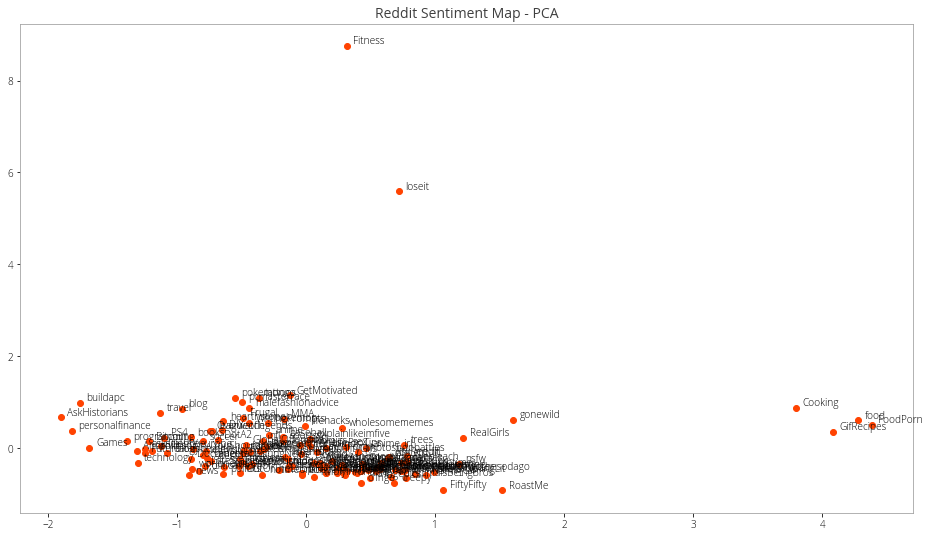

In [18]:
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)

out_pca = pca.fit_transform(dat)
generate_sentiment_map(out_pca, map_type="PCA")

#### Construct Low Dimensional Embedding with t-SNE
At the suggestion of Shuai, we will instead use the t-SNE algorithm to do dimensionality reduction on our emoji distributions. Because the t-SNE approach operates in a manner that engages in preserving local neighborhoods, it proves robust against outliers and is quite appropriate for this sort of task. Note, however, that with this embedding the euclidean distance between points is no longer a good approximation of sentimental distance between those associated subreddits; i.e. unlike PCA, t-SNE is non-convex and while it will naturally attempt to preserve high dimensional cluster locality in lower dimensions, it makes no guarantees that distances between clusters within the lower dimensional embedding holds much meaning (the global geometry also seems to be quite substantially sensitive to the perplexity parameter). This makes t-SNE great for visualization but not so great for learning interpolatable, latent space representations (it's not made for that anyways I don't think).

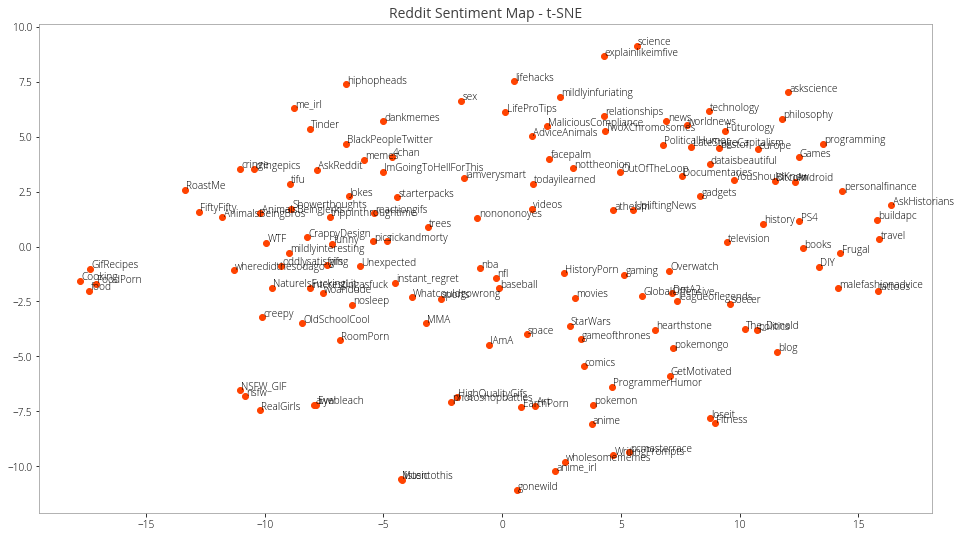

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate=10, early_exaggeration=20, perplexity=20)

out_tsne = tsne.fit_transform(dat)
generate_sentiment_map(out_tsne, map_type="t-SNE")

#### Highlights of Interesting t-SNE Clusters
Regardless, t-SNE in this case produces great results towards our end goal. Here, we manually highlight a few of the interesting clusters that show up within our embedding. Notably, subreddits from the following categories are featured:

- gaming
- sports
- fitness
- politics
- music
- nsfw
- misc
- food
- stem

An interesting thing to note here is how sports subreddits like r/nfl, r/nba, r/baseball, and r/sports are clustered together, however, r/soccer is not; this is perhaps an example of how interrelated subreddits with analogous subject matters, sports in this case, can still house discussions with diveregent sentimental atmospheres.

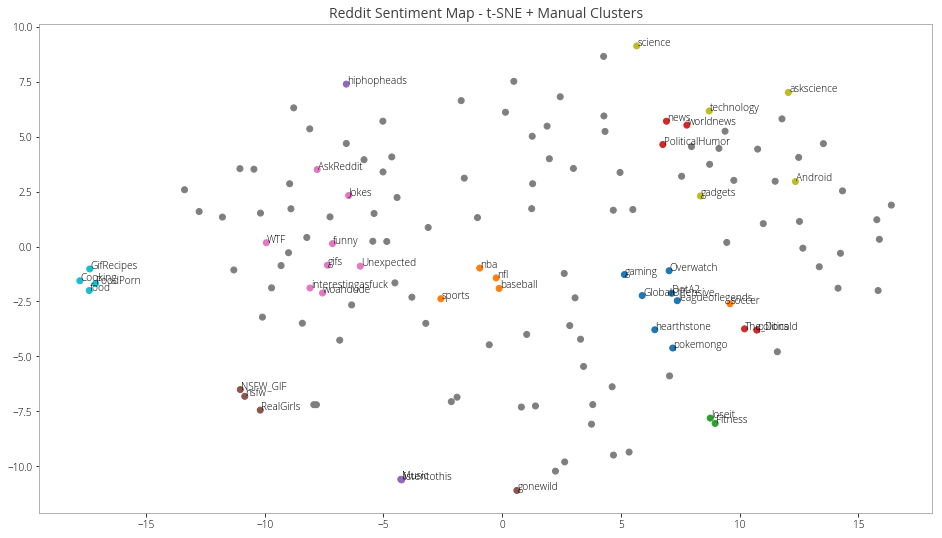

In [20]:
gaming_subs  = {"gaming", "leagueoflegends", "hearthstone", "dota2", "overwatch", "globaloffensive", "pokemongo"}
sport_subs   = {"sports", "nba", "nfl", "soccer", "baseball"}
fitness_subs = {"fitness", "loseit"}
politic_subs = {"politics", "politicalhumor", "the_donald", "worldnews", "news"}
music_subs   = {"music", "listentothis", "hiphopheads"}
nsfw_subs    = {"nsfw", "nsfw_gif", "realgirls", "gonewild"}
misc_subs    = {"askreddit", "jokes", "funny", "gifs", "unexpected", "wtf", "interestingasfuck", "woahdude"}
food_subs    = {"food", "cooking", "foodporn", "gifrecipes"}
stem_subs    = {"technology", "science", "askscience", "android", "gadgets"}

clusters = [gaming_subs, sport_subs, fitness_subs, politic_subs, music_subs, nsfw_subs, 
            misc_subs, food_subs, stem_subs]

cluster_labels = [list(i for i, cluster in enumerate(clusters) if sub.lower() in cluster)
                  for sub in subreddits]
cluster_labels = [7 if len(label) == 0 else (label[0] if label[0] != 7 else 9) for label in cluster_labels]

fig, ax = plt.subplots(figsize=(16,9))
plt.title("Reddit Sentiment Map - t-SNE + Manual Clusters", color="#404040", fontsize=14)
plt.scatter(out_tsne[:,0], out_tsne[:,1], c=cluster_labels, label=cluster_labels, cmap="tab10");

for i, sub in enumerate(df.subreddit.unique()[:num_subs]):
    if cluster_labels[i] != 7:
        plt.annotate(sub, (out_tsne[i,0] + 0.03, out_tsne[i,1] + 0.03))

plt.setp(ax.spines.values(), color="#A0A0A0")
plt.show()

#### Spectral Clustering with RBF Kernel
Now that we have a workable embedding, we will attempt to label subreddit clusters. Our first attempt will be with the spectral clustering algorithm, specifically using the default RBF kernel to generate the underlying affinity matrix. This gives us respectable results and is able to formulate sensible clusters to the eye. However, we will later come to see that the spectral clustering technique, somewhat from rough empirical insight, is not so well suited for this particular application (especially in comparison to something like K-means).

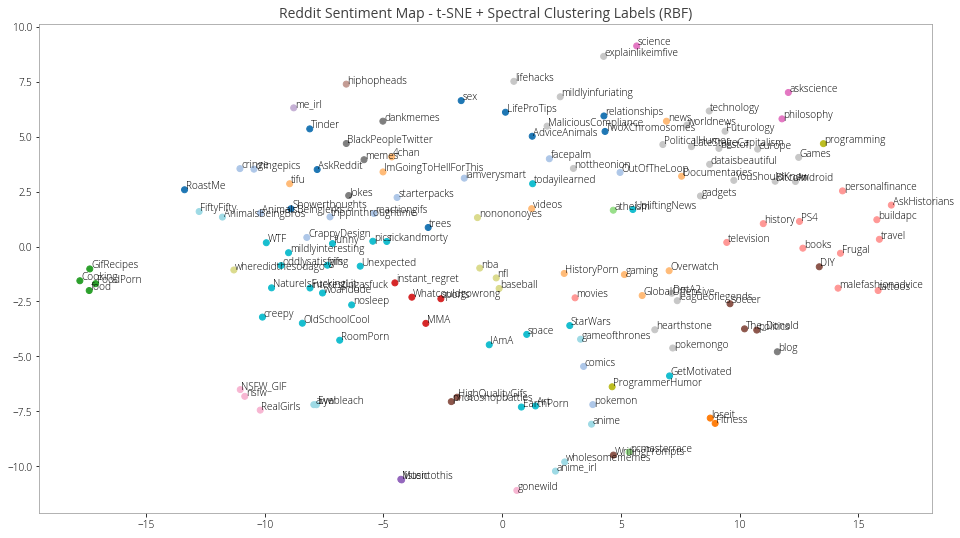

In [21]:
from sklearn.cluster import SpectralClustering

num_clusters = 20

sc = SpectralClustering(n_clusters=num_clusters, affinity="rbf", n_init=100, n_neighbors=5)

cluster_labels = sc.fit_predict(dat)

generate_sentiment_map(out_tsne, labels=cluster_labels, map_type="t-SNE + Spectral Clustering Labels (RBF)")

In [22]:
max_disp_subs = 75
reddit_color_scale = [
    [0.00, 'rgb(255,255,255)'],
    [0.25, 'rgb(254,224,144)'],
    [0.75, 'rgb(255,67,1)'],
    [1.00, 'rgb(255,0,0)']
]

def generate_subreddit_heatmap(matrix, max_disp_subs, title):
    data = [
        go.Heatmap(
            x=subreddits[:max_disp_subs],
            y=subreddits[:max_disp_subs],
            z=matrix[:max_disp_subs,:max_disp_subs],
            colorscale=reddit_color_scale
        )
    ]
    layout = dict(
        xaxis = dict(
            autorange=True,
            ticks="outside",
            dtick=1,
            ticklen=5,
            tickwidth=0
        ),
        yaxis = dict(
            autorange=True,
            ticks="outside",
            dtick=1,
            ticklen=5,
            tickwidth=0
        ),
        autosize=False,
        width=975, 
        height=975,
        margin = dict(
            l=130,
            b=130
        ),
        hovermode = "closest",
        hoverlabel = dict(
            bgcolor="black",
            font=dict(color="white")
        ),
        title = title
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, config={"displayModeBar": False})

In [23]:
generate_subreddit_heatmap(sc.affinity_matrix_, max_disp_subs, 
                           "Underlying Subreddit Affinity Matrix Generated by Spectral Clustering")

#### Calculate Pairwise Discrepancy of Emoji Distributions across Subreddits
Taking a peak at the underlying affinitiy matrix generated by the spectral clustering algorithm we may start to become curious as to what the sentimental distance between the various subreddits may look like; perhaps we can generate our own pre-computed affinity matrix with some metric that is more appropriate. Here is where JS divergence comes in. If we interpret each point representing a subreddit in 64-dimensional space as a probability distribution, we can find the *distance* between them by calculating the pairwise KL divergence between each subreddit; we will follow through with this line of reasoning but instead use JS distance instead of KL for purposes of symmetry. We can see that the generated JS matrix below is very similar to the affinity matrix above. In fact, we can convert our JS measure of *distance* into *affinity* by subtracting each element in the matrix from the max element of the JS matrix. This will generate an affinity matrix derived from JS distance that is very similar to the affinity matrix produced by spectral clustering with the RBF kernel. Perhaps this demonstrates some mathematical connection between the two methodologies but I'm not so sure at this point in time.

In [24]:
from scipy.stats import entropy
from numpy.linalg import norm

# Calculates Jensen-Shannon Divergence
def JSD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

# Calculuate pairwise J-S divergence and store in matrix
js_matrix = np.zeros([num_subs, num_subs])
for i in range(num_subs):
    for j in range(num_subs):
        js_matrix[i][j] = JSD(df_emoji_dists.drop("subreddit", axis=1).loc[i], \
                              df_emoji_dists.drop("subreddit", axis=1).loc[j])

In [25]:
generate_subreddit_heatmap(js_matrix, max_disp_subs, "J-S Divergence between Emoji Distributions across Subreddits")

#### Spectral Clustering with Affinity Matrix derived from J-S Divergence
We can feed our pre-computed affinity matrix to the spectral clustering algorithm and see that, expectedly, the clustering is very similar to our previous attempt.

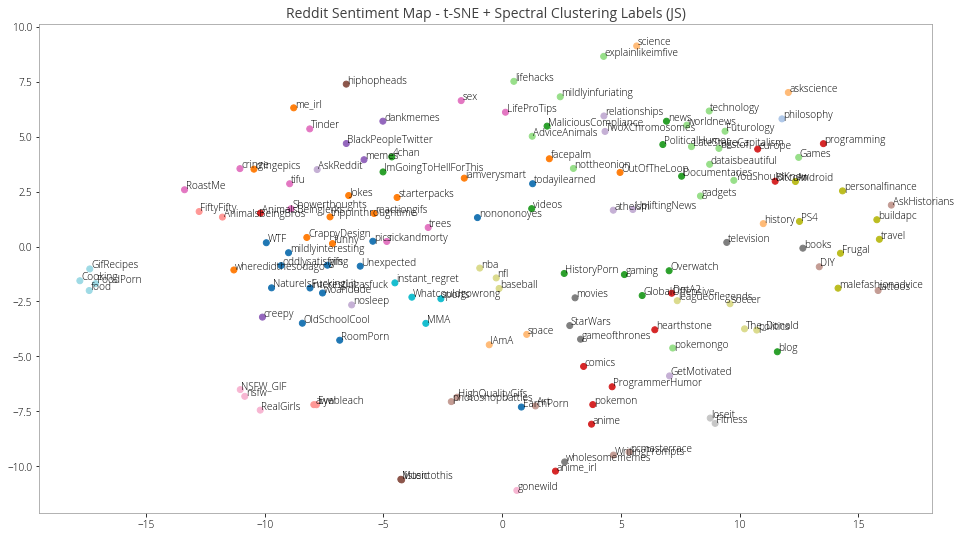

In [26]:
sc = SpectralClustering(n_clusters=num_clusters, affinity="precomputed", n_init=100)

aff_matrix     = js_matrix.max() - js_matrix
cluster_labels = sc.fit_predict(aff_matrix)

generate_sentiment_map(out_tsne, labels=cluster_labels, map_type="t-SNE + Spectral Clustering Labels (JS)")

#### K-Means Clustering
Falling back on more conventional methods, we attempt to generate a clustering with the K-means algorithm which actually proves to be rather effective. What isn't readily obvious is that spectral clustering's focus on graph connectivity makes it less suitable for this particular task and that K-means, which excels at finding globular clusters grouped by geometrical proximity, seems to be the more appropriate technique here.

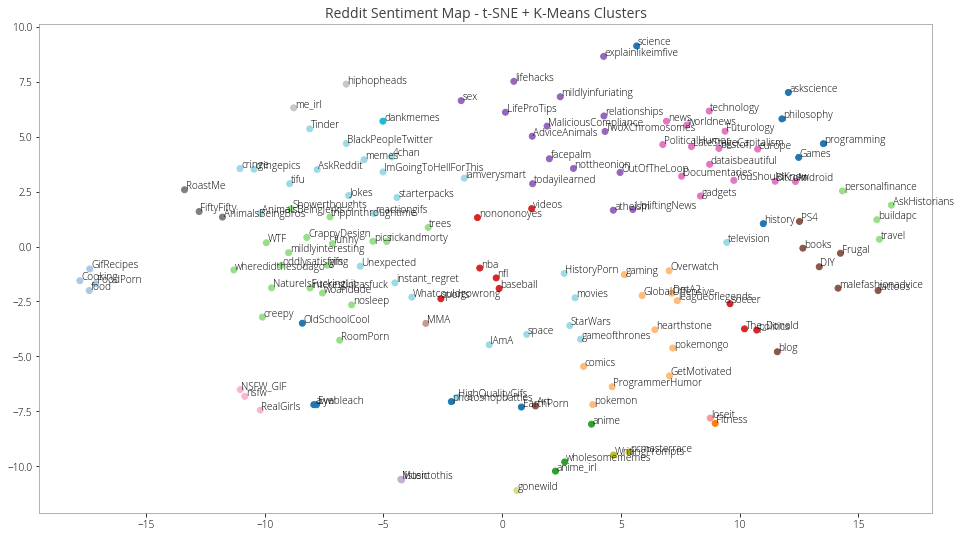

In [27]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=25, random_state=5, n_init=100)

cluster_labels = km.fit(dat)
cluster_labels = km.predict(dat)

generate_sentiment_map(out_tsne, labels=cluster_labels, map_type="t-SNE + K-Means Clusters")

#### Visualizing Strong Subreddit Sentimental Connections
Perhaps clusters don't tell the whole story; this thought urges us to pursue a different kind of visualization for our emoji distributions that would perhaps help elucidate the difference in results and effectiveness between applying K-means and spectral clustering. With this in mind, we generate a network graph for our data with subreddits as nodes and edges connecting between subreddits whose JS distance is lower than a predefined threshold (or rather in this case conversely that the pairwise affinity is higher than some predefined threshold--default 0.45). Interestingly enough, we see that even within some very obvious, strongly coupled, subreddit clusters, that the subreddits within those clusters don't have sufficient affinity to be connected. We can then deduce that t-SNE succesfully localizes these clusters as neighbors in the embedding due to their relative similarity; i.e. subreddits that are highly sentimentally idiosyncratic and are clustered together are not necessarily very similar to one another, but they are just so far removed from every other subreddit that they are forced into being neighbors. This could explain why spectral clustering, which focuses prominently on connectivity strength, fails to appropriately find these clusters and why on the other hand K-means, which focuses on relative geometric proximity, excels.

In [28]:
aff_thresh = 0.45

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=go.Line(width=0.5,color="#888"),
    hoverinfo="none",
    mode="lines"
)
node_trace = go.Scatter(
    x=[],
    y=[],
    text=subreddits,
    mode="markers",
    hoverinfo="text",
    marker=go.Marker(
        colorscale=[
            [0.00, "rgb(254,224,144)"],
            [0.50, "rgb(255,67,1)"],
            [1.00, "rgb(255,0,0)"]
        ],
        color=[],
        size=10
    )
)
layout=go.Layout(
    title="Network of Subreddits with Strong Sentimental Connections",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode="closest",
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=go.XAxis(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=go.YAxis(showgrid=False, zeroline=False, showticklabels=False)
)
    
for i in range(len(aff_matrix)):
    for j in range(i, len(aff_matrix)):
        if aff_matrix[i,j] > aff_thresh:
            edge_trace["x"] += [out_tsne[i][0], out_tsne[j][0], None]
            edge_trace["y"] += [out_tsne[i][1], out_tsne[j][1], None]
    
for x, y in out_tsne:
    node_trace["x"].append(x)
    node_trace["y"].append(y)

for i in range(len(aff_matrix)):
    node_trace["marker"]["color"].append(sum(aff_matrix[i] > aff_thresh) - 1)
    
fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
iplot(fig, config={"displayModeBar": False})

#### Interpreting Embedding Regions with Modes of Low-Dimensional Cluster Sentiments
We are now interested in segmenting our embedding into distinct regions and assigning each an emoji which should represent that region's (of subreddits) collective sentiment. This is quite a difficult task with many open ended solutions. I imagine that one can possibly conceive an intricate autoencoder scheme that couples the task of learning a latent representation with that of predicting sentiments of collections of subreddits by constraining the cost function in some way. This is far too advanced and currently out of the scope of my skills and thus I will instead make a highly simplified attempt at interpreting the various regions of our generated t-SNE embedding. The strategy is this, first create local clusters within the lower dimensional embedding and aggregate the emoji distributions of each subreddit within that cluster into one collective, per cluster, emoji distribution. Then, simply take the mode (emoji) of the distribution and assign that emoji as the *collective sentiment* of that embedding region populated by the subreddits that constitute that cluster.

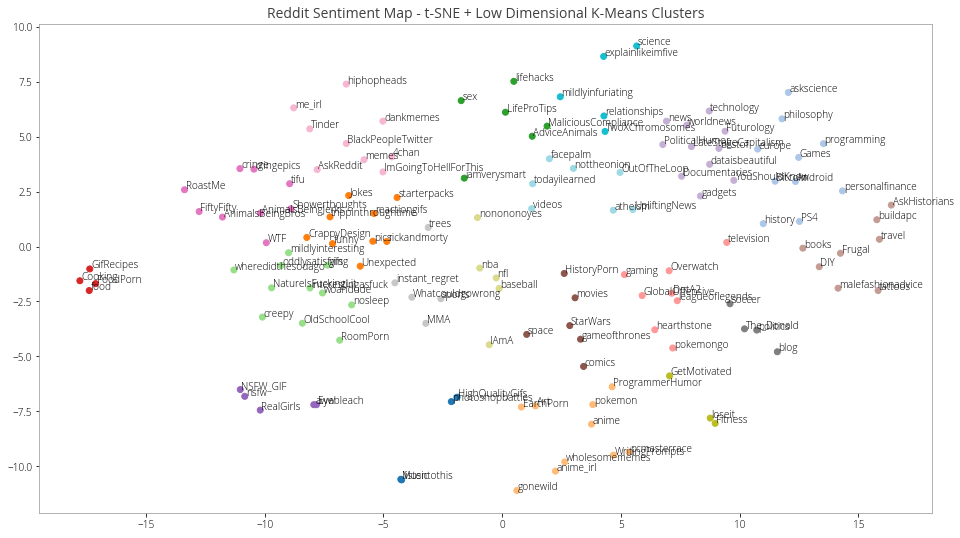

In [29]:
km = KMeans(n_clusters=num_clusters, random_state=5, n_init=100)

cluster_labels_ld = km.fit(out_tsne)
cluster_labels_ld = km.predict(out_tsne)

generate_sentiment_map(out_tsne, labels=cluster_labels_ld, map_type="t-SNE + Low Dimensional K-Means Clusters")

In [30]:
cluster_subs = [[] for x in range(num_clusters)]

for i, cluster in enumerate(cluster_labels_ld):
    cluster_subs[cluster].append(i)

cluster_emoji_dists = [np.zeros(64) for _ in range(num_clusters)]
for cluster, subs in enumerate(cluster_subs):
    for sub in subs:
        cluster_emoji_dists[cluster] += \
            np.array(df_emoji_dists[df_emoji_dists.subreddit == subreddits[sub]].drop("subreddit", axis=1)).reshape(-1)
            
cluster_emoji_modes = [np.argmax(emoji_dists) for emoji_dists in cluster_emoji_dists]
cluster_centroids   = km.cluster_centers_.transpose()

In [31]:
cluster_num = 0

data = [
    go.Bar(
        x=[emoji_map[i] for i in range(64)], 
        y=cluster_emoji_dists[cluster_num],
        marker=dict(
            color="rgb(255,67,1)"
        )
    )
]
layout = go.Layout(
    xaxis = dict(
        autotick=False,
        ticks="outside",
        dtick=1,
        ticklen=0,
        tickwidth=0,
        tickangle=0
    ), 
    hovermode = "closest",
    hoverlabel = dict(
        bgcolor="black",
        font= dict(color="white")
    ),
    title="Non-normalized Emoji Distribution of Cluster " + str(cluster_num)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, config={"displayModeBar": False})

In [32]:
subs_trace = go.Scatter(
    x=out_tsne[:,0],
    y=out_tsne[:,1],
    text=subreddits,
    mode="markers",
    hoverinfo="text",
    marker=go.Marker(
        color="#888888",
        size=7
    )
)
clusters_trace = go.Scatter(
    x=cluster_centroids[0],
    y=cluster_centroids[1],
    mode="text",
    text=[emoji_map[emoji] for emoji in cluster_emoji_modes],
    textfont=dict(
        size=18,
    ),
    hoverinfo="none"
)
layout = go.Layout(
    title="t-SNE Embedding Divided by Emoji Distribution Modes of K-means Clusters",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode="closest",
    hoverlabel = dict(
        bgcolor="black",
        font=dict(color="white")
    ),
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=go.XAxis(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=go.YAxis(showgrid=False, zeroline=False, showticklabels=False)
)

fig = go.Figure(data=[subs_trace, clusters_trace], layout=layout)
iplot(fig, config={"displayModeBar": False})

### Putting It All Together
***
We've now examined various interesting aspects of our sentiment data, investigated a handful of neat techniques for data analysis, and successfully gathered up some useful results from our explorative endeavor. Assembling these diverse components together, we can now establish a somewhat polished *Reddit Sentiment Map* of sorts that is the culmination of our lighthearted scientific expedition.

In [33]:
subs_trace = go.Scatter(
    x=out_tsne[:,0],
    y=out_tsne[:,1],
    text=subreddits,
    mode="markers+text",
    hoverinfo="text",
    textposition="top right",
    marker=go.Marker(
        color=[label / len(cluster_labels) for label in cluster_labels],
        colorscale="Portland",
        size=7
    )
)
clusters_trace = go.Scatter(
    x=cluster_centroids[0],
    y=cluster_centroids[1],
    mode="text",
    text=[emoji_map[emoji] for emoji in cluster_emoji_modes],
    textfont=dict(
        size=18,
    ),
    hoverinfo="none"
)
layout = go.Layout(
    title="Reddit Sentiment Map",
    titlefont=dict(size=16),
    showlegend=False,
    hovermode="closest",
    hoverlabel = dict(
        bgcolor="black",
        font=dict(color="white")
    ),
    margin=dict(b=20, l=5, r=5, t=40),
    xaxis=go.XAxis(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=go.YAxis(showgrid=False, zeroline=False, showticklabels=False),
    dragmode="pan"
)

fig = go.Figure(data=[edge_trace, subs_trace, clusters_trace], layout=layout)
config = dict(
    scrollZoom=True, 
    displayModeBar=False
)
iplot(fig, config=config)

### Privacy/Ethics Consideration
***
Besides the obvious chronological bias in the data (that this chunk of Reddit comment data from March 2017 may not be wholly representative of all comments made over time), there is not much cause for concern in terms of privacy and ethical considerations--due to the comprehensive nature of the dataset, in that it equitably includes all comments made within a particular timeframe, there is no selective prejudice in terms of what comments are accessible to be analyzed. Additionally, the analysis focuses primarily on comment bodies and strips away any notion of authorship from each comment before it is processed and analyzed for sentimental value. Regardless, because these comments are public posts made online and users are anonymous by nature, we can safely assume that their privacy is not breached in this particular study. As for ethical considerations, we can imagine that the greatest extent of harm could come from mislabelling certain communities as promoting certain types of discourses and sentiments that they might not actually be. If such is the case, this is a fault of our combined methodologies, regardless, really no one should feel offended by the results of this rather playful analysis--what we offer is merely a *possible* representation of Reddit communal sentiments and any ridiculous assertion that this study aims to deface certain subreddit communities is wholly unfounded.

### Conclusions and Discussion
***
By exploration of various analytical methods, we've been able to construct a map of Reddit that visually illustrates the internal diversity of its communal sentiments; we've shown that the very intriguing DeepMoji model can be utilized to assist us with this construction, and that in combination with other powerful data analytic techniques, we are able to successfully carry out a lighthearted study that combines two amusing and somewhat outlandish aspects of modern culture, *Reddit and Emojis*. 

This is a neat little project that could serve as a foray into more serious and rigorous studies but, alas, it really shouldn't be taken all too seriously in its current form. The principal foundation upon which excellent data analysis is carried out lies in the preprocessing, cleaning, and sampling of data. With regards to this, we've done an acceptable job of hacking everything to cooperate nicely together and produce somewhat meaningful results, yet at the same time we've really done a lackluster job of upholding the integrity of our study. To really tackle this idea with any degree of seriousness, which would require significantly more time than currently available, much more meticulous steps must be taken to ensure that our sampling strategy is robust, that the very critical DeepMoji model is able to incorporate analysis of comments that are much longer and more diverse, and that we have sufficient datapoints and computational power to extend and scale our study as necessary. 

Regardless, there really is a lot of complexity to human sentiments and this study simply does not do it justice. Future works should especially look to focus on building a sentiment embedding that is interprettable; one that maintains significance in distances between points and clusters and one whose manifold regions are interpolatable and can be interpreted as gradients of shifting sentiments. As ridiculous as it may sound, we should also seek to develop a better understanding of emojis themselves--consider, for example, building visualizations of emoji cooccurrences to qualify the interactions and relationships between the underlying human sentiments embedded in these frivolous digital figures. For now though, this is probably as far as I'll be able to go with this silly little idea of *Reddit and Emojis*.

### Extras
***
Some ideas were tinkered with that didn't work out all too well; with more extensive tweaking and further polish perhaps we could hope to incorporate these promising ideas into our work in the future. These "failed" experiments are included below for your viewing pleasure.

#### Estimate Relative Subreddit Sentimental Conformity using Shannon's Entropy

In [34]:
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler

ent_arr = entropy(df_emoji_dists.drop("subreddit", axis=1)[:num_subs].T)
ent_arr = [1 - ent[0] for ent in MinMaxScaler().fit_transform(ent_arr.reshape(-1, 1))]
ent_arr_sorted = [(sub, ent) for sub, ent in zip(subreddits[:num_subs], ent_arr)]
ent_arr_sorted.sort(key=lambda tup: tup[1], reverse=True)

data = [
    go.Bar(
        x=[ent[0] for ent in ent_arr_sorted][:max_disp_subs], 
        y=[ent[1] for ent in ent_arr_sorted][:max_disp_subs],
        marker=dict(
            color="rgb(255,67,1)"
        )
    )
]
layout = go.Layout(
    xaxis = dict(
        autotick=False,
        ticks="outside",
        dtick=1,
        ticklen=0,
        tickwidth=0
    ), 
    hovermode = "closest",
    hoverlabel = dict(
        bgcolor="black",
        font= dict(color="white")
    ),
    margin = dict(
        b=130
    ),
    title = "Estimated Relative Subreddit Sentimental Conformity"
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, config={"displayModeBar": False})

#### Estimated Sentimental Conformity vs. t-SNE Embedding

In [35]:
trace1 = go.Scatter3d(
    x=out_tsne[:,0],
    y=out_tsne[:,1],
    z=ent_arr,
    name=subreddits,
    mode='markers',
    marker=dict(
        size=12,
        color=ent_arr,
        colorscale=[
            [0.00, 'rgb(255,255,255)'],
            [0.25, 'rgb(254,224,144)'],
            [0.75, 'rgb(255,67,1)'],
            [1.00, 'rgb(255,0,0)']
        ],
        opacity=0.8
    )
)
data = [trace1]
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0)
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#### Incorporating Controversiality

In [36]:
cont_arr = [1 - df[df.subreddit == sub]["controversiality"].value_counts(normalize=True)[0] \
            for sub in subreddits[:num_subs]]
cont_arr = [cont[0] for cont in MinMaxScaler().fit_transform(np.array(cont_arr).reshape(-1, 1))]
cont_arr_sorted = [(sub, cont) for sub, cont in zip(subreddits[:num_subs], cont_arr)]
cont_arr_sorted.sort(key=lambda tup: tup[1], reverse=True)

data = [
    go.Bar(
        x=[cont[0] for cont in cont_arr_sorted][:max_disp_subs], 
        y=[cont[1] for cont in cont_arr_sorted][:max_disp_subs],
        marker=dict(
            color="rgb(255,67,1)"
        )
    )
]
layout = go.Layout(
    xaxis = dict(
        autotick=False,
        ticks="outside",
        dtick=1,
        ticklen=0,
        tickwidth=0
    ), 
    hovermode = "closest",
    hoverlabel = dict(
        bgcolor="black",
        font= dict(color="white")
    ),
    margin = dict(
        b=130
    ),
    title = "Subreddit Controversiality"
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, config={"displayModeBar": False})

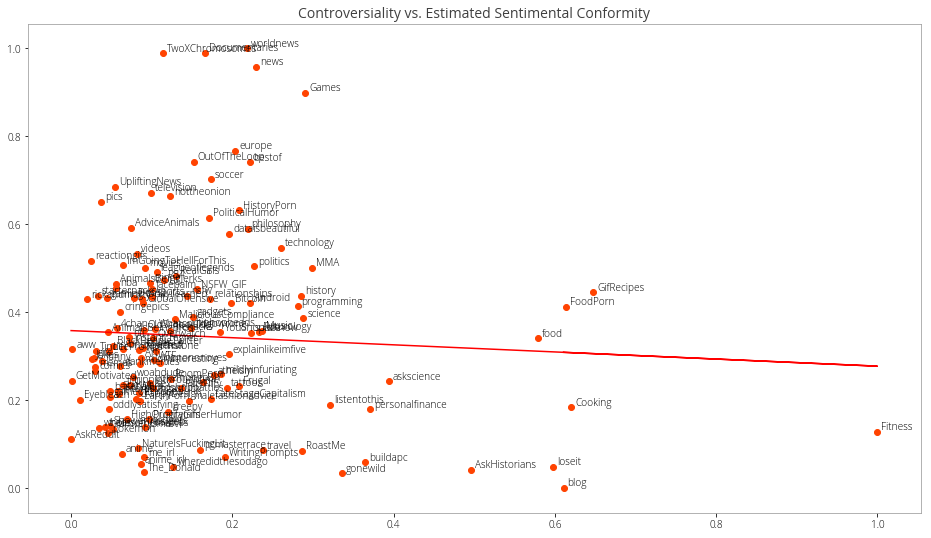

In [37]:
ent_cont_arr = [ent_arr, cont_arr]

fig, ax = plt.subplots(figsize=(16,9))
plt.title("Controversiality vs. Estimated Sentimental Conformity", color="#404040", fontsize=14)
ax.scatter(ent_cont_arr[0], ent_cont_arr[1], c="#FF4301");

for i, sub in enumerate(df.subreddit.unique()[:num_subs]):
    ax.annotate(sub, (ent_cont_arr[0][i] + 0.005, ent_cont_arr[1][i] + 0.005))
    
m, b = np.polyfit(ent_cont_arr[0], ent_cont_arr[1], 1)
ax.plot(ent_cont_arr[0], [m * x + b for x in ent_cont_arr[0]], color='red')

plt.setp(ax.spines.values(), color="#A0A0A0")
plt.show()

#### Controversial vs. Non-Controversial Emoji Distributions

In [38]:
emoji_counts_0 = df[df.controversiality == 0]["emoji"].value_counts(normalize=True).sort_index()
emoji_counts_1 = df[df.controversiality == 1]["emoji"].value_counts(normalize=True).sort_index()

trace1 = go.Bar(
    x=[emoji_map[i] for i in emoji_counts_0.index], 
    y=emoji_counts_0,
    marker=dict(
        color="#AAAAAA"
    ),
    name="Non-Controversial"
)
trace2 = go.Bar(
    x=[emoji_map[i] for i in emoji_counts_1.index], 
    y=emoji_counts_1,
    marker=dict(
        color="rgb(255,67,1)"
    ),
    name="Controversial"
)
data = [trace1, trace2]
layout = go.Layout(
    xaxis = dict(
        autotick=False,
        ticks="outside",
        dtick=1,
        ticklen=0,
        tickwidth=0,
        tickangle=0
    ), 
    hovermode = "closest",
    hoverlabel = dict(
        bgcolor="black",
        font= dict(color="white")
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, config={"displayModeBar": False})